In [26]:
%matplotlib inline
import matplotlib.pylab

In [1]:
import os
import mne
import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
from pylab import savefig

import pylab as pl
from IPython.display import display

import glob
import copy

pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import seaborn as sns
sns.set_context(rc={"figure.figsize": (10,10),'font.size': 16})

#%matplotlib inline

height has been deprecated.



/Users/kevinsitek/miniconda/lib/python2.7/site-packages/pandas/core/config.py:614: DeprecationWarning: height has been deprecated.

  warnings.warn(d.msg, DeprecationWarning)


#### Define subject groups:

In [2]:
pfs = [ 1,  2,  4, 10, 12, 13, 17, 18, 21, 22, 23, 24, 26, 29, 30, 31, 34, 37, 38] # [24] (S25) is full of nan
pws = [ 0,  3,  5,  6,  7,  8,  9, 11, 14, 15, 16, 19, 20, 25, 27, 28, 32, 33, 35, 36]

pws_bin = np.zeros(39)
pws_bin[pws] = 1

#### Define directory paths:

In [3]:
restdir = '/Users/kevinsitek/om/om/user/ksitek/STUT/resting/'
aparc_results = 'parcellations/aparc/'

#### Connect to openmind via SSHFS:

In [4]:
if ~os.path.isdir(restdir):
    os.system("sshfs ~/om ksitek@openmind7.mit.edu:/ -o defer_permissions")

#### Load freesurfer lookup table:

In [5]:
fsLUT_file = '/Users/kevinsitek/om/om/user/ksitek/STUT/scripts/reference_files/FreeSurferColorLUT.txt'
fsLUT = pd.read_table(fsLUT_file,skiprows=4)

### Get ROI names:

In [6]:
for sx, s in enumerate(sorted(os.listdir(restdir))):
    #if len(roi_list > 0):
    if s[0] == 'S' and s !='S25' and s !='S09': # S25 has a weird lh-frontalpole - ends up nan after corrcoef & fisher

        subdir = os.path.join(restdir,s,'resting')

        # ROI names
        sumstats_file = os.path.join(subdir,aparc_results,'rest_01_summary.stats')
        sumstats = pd.read_csv(sumstats_file,header=None,skiprows=53)
        roi = []
        roi_list = []
        for r in range(0,sumstats.shape[0]):
            roi = sumstats[0][r][30:64]
            roi = roi.strip()
            roi_list.append(roi)


In [7]:
roi_list

['Left-Cerebellum-Cortex',
 'Left-Thalamus-Proper',
 'Left-Caudate',
 'Left-Putamen',
 'Left-Pallidum',
 'Left-Hippocampus',
 'Left-Amygdala',
 'Left-Accumbens-area',
 'Right-Cerebellum-Cortex',
 'Right-Thalamus-Proper',
 'Right-Caudate',
 'Right-Putamen',
 'Right-Pallidum',
 'Right-Hippocampus',
 'Right-Amygdala',
 'Right-Accumbens-area',
 'ctx-lh-bankssts',
 'ctx-lh-caudalanteriorcingulate',
 'ctx-lh-caudalmiddlefrontal',
 'ctx-lh-cuneus',
 'ctx-lh-entorhinal',
 'ctx-lh-fusiform',
 'ctx-lh-inferiorparietal',
 'ctx-lh-inferiortemporal',
 'ctx-lh-isthmuscingulate',
 'ctx-lh-lateraloccipital',
 'ctx-lh-lateralorbitofrontal',
 'ctx-lh-lingual',
 'ctx-lh-medialorbitofrontal',
 'ctx-lh-middletemporal',
 'ctx-lh-parahippocampal',
 'ctx-lh-paracentral',
 'ctx-lh-parsopercularis',
 'ctx-lh-parsorbitalis',
 'ctx-lh-parstriangularis',
 'ctx-lh-pericalcarine',
 'ctx-lh-postcentral',
 'ctx-lh-posteriorcingulate',
 'ctx-lh-precentral',
 'ctx-lh-precuneus',
 'ctx-lh-rostralanteriorcingulate',
 'ctx

In [8]:
names = []
for rn in range(0,len(roi_list)):#rs_timecorr.shape[1]):
    names.append(roi_list[rn])

#### Reorder into structurally similar groups:

In [9]:
# want the mne circle plot to have anterior on left, posterior on right, with rh on top and lh on bottom
# start with posterior rh

anat_order = ['Right-Cerebellum-Cortex',\
              'Right-Thalamus-Proper','Right-Pallidum','Right-Putamen','Right-Caudate', 'Right-Hippocampus','Right-Amygdala','Right-Accumbens-area',\
              'wm-rh-lateraloccipital','wm-rh-lingual','wm-rh-cuneus','wm-rh-pericalcarine',\
              'wm-rh-precuneus','wm-rh-superiorparietal','wm-rh-inferiorparietal','wm-rh-supramarginal',\
              'wm-rh-parahippocampal','wm-rh-entorhinal','wm-rh-fusiform','wm-rh-inferiortemporal','wm-rh-temporalpole','wm-rh-middletemporal','wm-rh-transversetemporal','wm-rh-bankssts','wm-rh-superiortemporal',\
              'wm-rh-insula',\
              'wm-rh-posteriorcingulate','wm-rh-isthmuscingulate','wm-rh-caudalanteriorcingulate','wm-rh-rostralanteriorcingulate',\
              'wm-rh-paracentral','wm-rh-postcentral','wm-rh-precentral', \
              'wm-rh-parsopercularis','wm-rh-parstriangularis','wm-rh-parsorbitalis','wm-rh-lateralorbitofrontal','wm-rh-caudalmiddlefrontal','wm-rh-medialorbitofrontal','wm-rh-rostralmiddlefrontal','wm-rh-superiorfrontal','wm-rh-frontalpole',\
              'wm-lh-frontalpole','wm-lh-superiorfrontal', 'wm-lh-rostralmiddlefrontal','wm-lh-medialorbitofrontal','wm-lh-caudalmiddlefrontal', \
              'wm-lh-lateralorbitofrontal','wm-lh-parsorbitalis','wm-lh-parstriangularis','wm-lh-parsopercularis',\
              'wm-lh-precentral','wm-lh-postcentral','wm-lh-paracentral','wm-lh-rostralanteriorcingulate', \
              'wm-lh-caudalanteriorcingulate','wm-lh-posteriorcingulate','wm-lh-isthmuscingulate','wm-lh-insula',\
              'wm-lh-superiortemporal','wm-lh-bankssts','wm-lh-transversetemporal','wm-lh-middletemporal', \
              'wm-lh-temporalpole','wm-lh-inferiortemporal','wm-lh-fusiform','wm-lh-entorhinal','wm-lh-parahippocampal',\
              'wm-lh-supramarginal',\
              'wm-lh-inferiorparietal','wm-lh-superiorparietal','wm-lh-precuneus','wm-lh-pericalcarine','wm-lh-cuneus',\
              'wm-lh-lingual','wm-lh-lateraloccipital','Left-Accumbens-area','Left-Amygdala', \
              'Left-Hippocampus','Left-Caudate','Left-Putamen','Left-Pallidum','Left-Thalamus-Proper', \
              'Left-Cerebellum-Cortex'] 
'''order:
[brainstem, right_cerebellum, right_subcort, right_cortex, right_occipital, right_parietal, \
right_temporal, right_insula, right_cingulate,right_frontal,right_central_frontal,right_medinf_frontal, \
right_suplat_frontal,left_suplat_frontal,left_medinf_frontal,left_central_frontal,left_frontal, \
left_cingulate,left_insula,left_suplat_temporal,left_medinf_temporal,left_temporal,left_parietal,left_occipital, \
left_cortex,left_subcort, left_cerebellum])
'''
anat_order.reverse()

anat_order = [n.replace('wm-','ctx-') for n in anat_order]

anat_num_order = np.zeros((len(anat_order),1))
for ax,anat in enumerate(anat_order):
    anat_num_order[ax] = int(list(names).index(anat))

In [10]:
roi_list_sh = []
for r in anat_order:#roi_list:
    if r[0:4] == 'ctx-':
        roi_list_sh.append(r[4:])
    elif r[-7:]=='-Cortex':
        roi_list_sh.append(r[:-7])
    elif r[-7:]=='-Proper':
        roi_list_sh.append(r[:-7])
    elif r[-5:]=='-area':
        roi_list_sh.append(r[:-5])
    else:
        roi_list_sh.append(r)
print roi_list_sh

['Left-Cerebellum', 'Left-Thalamus', 'Left-Pallidum', 'Left-Putamen', 'Left-Caudate', 'Left-Hippocampus', 'Left-Amygdala', 'Left-Accumbens', 'lh-lateraloccipital', 'lh-lingual', 'lh-cuneus', 'lh-pericalcarine', 'lh-precuneus', 'lh-superiorparietal', 'lh-inferiorparietal', 'lh-supramarginal', 'lh-parahippocampal', 'lh-entorhinal', 'lh-fusiform', 'lh-inferiortemporal', 'lh-temporalpole', 'lh-middletemporal', 'lh-transversetemporal', 'lh-bankssts', 'lh-superiortemporal', 'lh-insula', 'lh-isthmuscingulate', 'lh-posteriorcingulate', 'lh-caudalanteriorcingulate', 'lh-rostralanteriorcingulate', 'lh-paracentral', 'lh-postcentral', 'lh-precentral', 'lh-parsopercularis', 'lh-parstriangularis', 'lh-parsorbitalis', 'lh-lateralorbitofrontal', 'lh-caudalmiddlefrontal', 'lh-medialorbitofrontal', 'lh-rostralmiddlefrontal', 'lh-superiorfrontal', 'lh-frontalpole', 'rh-frontalpole', 'rh-superiorfrontal', 'rh-rostralmiddlefrontal', 'rh-medialorbitofrontal', 'rh-caudalmiddlefrontal', 'rh-lateralorbitofront

### Extract resting state timecourse data

#### For each subject, run cross-correlations across all ROIs and save as ROIxROI timecorr matrix:

In [11]:
anat_num_order[:5]

array([[ 0.],
       [ 1.],
       [ 4.],
       [ 3.],
       [ 2.]])

In [12]:
pws_i = 0
pfs_i = 0
rs_timecorr_pws = []
rs_timecorr_pfs = []
pws_subs = []
pfs_subs = []

n_subs = 0
rs_timecorr_allsubs = []
all_subs = []

for sx, s in enumerate(sorted(os.listdir(restdir))):
    if s[0] == 'S' and s !='S25' and s !='S09': # S25 has a weird lh-frontalpole - ends up nan after corrcoef & fisher
        
        subdir = os.path.join(restdir,s,'resting')

        # timecourse data
        avgwf_file = os.path.join(subdir,aparc_results,'rest_01_avgwf.txt')
        avgwf = np.loadtxt(avgwf_file)
        rs_timecorr = np.zeros((avgwf.shape[1],avgwf.shape[1]))
        # for roi_reorder, see below in ROI names section:
        for ix, r in enumerate(anat_num_order):#range(0,avgwf.shape[1]):
            r = int(r)
            for inx, rn in enumerate(anat_num_order):
                rn = int(rn)
                #rs_timecorr[r,rn] = np.correlate(avgwf[:,r],avgwf[:,rn])
                # arctanh = Fisher transform:
                rs_timecorr[ix,inx] = np.arctanh(np.corrcoef(avgwf[:,r],avgwf[:,rn])[0,1]) 
                
                # changed 3/11/16 - shouldn't this be by anat_num_order, not by ix?
                #rs_timecorr[r,rn] = np.arctanh(np.corrcoef(avgwf[:,r],avgwf[:,rn])[0,1])
                # 3/12: ^^ NO. we want to reorder the data
                
        #timefile = os.path.join(subdir,aparc_results,'time_corr.txt')
        #np.savetxt(timefile, rs_timecorr)
        
        if n_subs == 0:
            rs_timecorr_allsubs = rs_timecorr
            rs_timeseries = avgwf
        else:
            rs_timecorr_allsubs = np.vstack((rs_timecorr_allsubs, rs_timecorr))
            rs_timeseries = np.vstack((rs_timeseries,avgwf))
        all_subs.append(s)
        n_subs += 1
        #rs_timecorr_allsubs = np.vstack((rs_timecorr_allsubs, rs_timecorr))

        
        # add to group-level data
        a = np.array(s[1:3])
        if a.astype(int) - 1 in pws:
            if pws_i == 0:
                rs_timecorr_pws = rs_timecorr
            else:
                rs_timecorr_pws = np.vstack((rs_timecorr_pws,rs_timecorr))
            pws_i += 1
            pws_subs.append(s)
        else:
            if pfs_i == 0:
                rs_timecorr_pfs = rs_timecorr
            else:
                rs_timecorr_pfs = np.vstack((rs_timecorr_pfs,rs_timecorr))
            pfs_i += 1
            pfs_subs.append(s)

# reshape to 3D (subj x ROI x ROI)
rs_timeseries = rs_timeseries.reshape((n_subs,-1,84))
rs_timecorr_allsubs = rs_timecorr_allsubs.reshape((n_subs,-1,84))
rs_timecorr_pws = rs_timecorr_pws.reshape((pws_i,-1,84))
rs_timecorr_pfs = rs_timecorr_pfs.reshape((pfs_i,-1,84))

In [13]:
#check data
s=8

In [14]:
print rs_timecorr_allsubs[s,38:44,38:44]

sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
f, ax = plt.subplots(figsize=(14,14))
ax.set_title('subject %s correlations'%(all_subs[s]))
sns.color_palette("RdBu_r")
sns.corrplot(rs_timecorr_allsubs[s,:,:], annot=False, sig_stars=False,
             diag_names=False, ax=ax, names = roi_list_sh)
f.tight_layout()

#s+=1

/Users/kevinsitek/miniconda/lib/python2.7/site-packages/seaborn/linearmodels.py:1283: UserWarning: The `corrplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `corrplot` function has been deprecated in favor "
/Users/kevinsitek/miniconda/lib/python2.7/site-packages/seaborn/linearmodels.py:1349: UserWarning: The `symmatplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `symmatplot` function has been deprecated in favor "
/Users/kevinsitek/miniconda/lib/python2.7/site-packages/matplotlib/tight_layout.py:225: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


[[        inf  0.37571049  0.33036605  0.51741959  0.86402821  0.27503728]
 [ 0.37571049         inf  0.39854751  0.32260172  0.3639249   0.37933832]
 [ 0.33036605  0.39854751         inf  0.56232316  0.14018431  1.04442967]
 [ 0.51741959  0.32260172  0.56232316         inf  0.38123209  0.38251857]
 [ 0.86402821  0.3639249   0.14018431  0.38123209         inf  0.1247205 ]
 [ 0.27503728  0.37933832  1.04442967  0.38251857  0.1247205          inf]]


Alternatively, load existing files:

In [15]:
# np.genfromtxt()

In [16]:
print rs_timecorr_allsubs.shape
print rs_timecorr_pfs.shape
print rs_timecorr_pws.shape

(36, 84, 84)
(17, 84, 84)
(19, 84, 84)


#### Get the mean value across subjects (within each group):

In [17]:
rs_mean_pws = np.mean(rs_timecorr_pws,axis=0)
rs_mean_pfs = np.mean(rs_timecorr_pfs,axis=0)
print rs_mean_pfs.shape
print rs_mean_pws.shape

(84, 84)
(84, 84)


In [18]:
rs_mean_pfs[38:44,38:44]

array([[        inf,  0.3172677 ,  0.37600888,  0.27838919,  0.33971535,
         0.16331481],
       [ 0.3172677 ,         nan,  0.75067695,  0.16832501,  0.26452808,
         0.49682193],
       [ 0.37600888,  0.75067695,         nan,  0.13109047,  0.09531595,
         0.93470178],
       [ 0.27838919,  0.16832501,  0.13109047,         nan,  0.50426755,
         0.11592621],
       [ 0.33971535,  0.26452808,  0.09531595,  0.50426755,         nan,
         0.17285558],
       [ 0.16331481,  0.49682193,  0.93470178,  0.11592621,  0.17285558,
                nan]])

**hierarchical clustering**

In [20]:
import scipy.cluster.hierarchy as hier

In [21]:
plt.figure(figsize=(14,20))
ax = plt.axes([0.1, 0.1, 0.8, 0.8])

X = np.mean(rs_timeseries[data_status,:,:],axis=0)
Z = hier.linkage(X, 'single','correlation')
hier.dendrogram(Z, ax=ax,labels=roi_list, leaf_font_size=20, orientation='right',distance_sort='descendant');
# rs_timeseries is in the same order as roi_list but NOT roi_list_sh

NameError: name 'data_status' is not defined

## t-test between groups for each ROI-ROI correlation

In [20]:
t_mat = np.zeros((rs_mean_pfs.shape))
p_mat = np.zeros((rs_mean_pfs.shape))
p05x = 0
p033x = 0
p03x = 0
p02x = 0
p025x = 0
p01x = 0
for col in range(0,rs_timecorr_pws.shape[1]):
    for row in range(0,rs_timecorr_pws.shape[2]):
        t, p = stats.ttest_ind(rs_timecorr_pfs[:,row,col],rs_timecorr_pws[:,row,col])
        t_mat[row,col] = t
        p_mat[row,col] = p
        #print 't-value = %5f, p-value = %5f'%(t,p)
        
        if p <= 0.001:
            sig = '****'
        elif p <= 0.005:
            sig = ' ***'
        elif p <= 0.01:
            sig = '  **'
            p01x += 1
        elif p <=.02:
            sig = '   *'
            p02x += 1
        else:
            sig = '    '
        
        if p <= 0.03:
            p03x += 1
        if p <= 0.033:
            p033x += 1
        if p <= 0.025:
            p025x += 1
            
        if p <= 0.05: #roi_list_sh[col]=='lh-rostralmiddlefrontal':#
            print " %st = %1.2f;  p = %1.3f; seed: %s - target: %s" % (sig, t, p, roi_list_sh[col], roi_list_sh[row])
            p05x += 1

     t = -2.17;  p = 0.037; seed: Left-Cerebellum - target: Left-Thalamus
     t = -2.29;  p = 0.028; seed: Left-Cerebellum - target: Right-Putamen
     t = -2.11;  p = 0.042; seed: Left-Cerebellum - target: Right-Thalamus
     t = -2.17;  p = 0.037; seed: Left-Thalamus - target: Left-Cerebellum
     t = -2.30;  p = 0.028; seed: Left-Thalamus - target: Right-Cerebellum
     t = -2.23;  p = 0.032; seed: Left-Pallidum - target: rh-lateralorbitofrontal
     t = -2.05;  p = 0.048; seed: Left-Pallidum - target: rh-superiortemporal
     t = 2.05;  p = 0.048; seed: Left-Putamen - target: Right-Accumbens
     t = 2.30;  p = 0.028; seed: Left-Caudate - target: rh-parstriangularis
     t = 2.16;  p = 0.038; seed: Left-Caudate - target: rh-supramarginal
     t = 2.05;  p = 0.049; seed: Left-Caudate - target: rh-inferiorparietal
    *t = 2.55;  p = 0.015; seed: Left-Amygdala - target: lh-precuneus
    *t = 2.58;  p = 0.014; seed: Left-Amygdala - target: lh-inferiorparietal
     t = 2.06;  p = 0.04

In [21]:
p025x

84

In [ ]:
# FDR correction
from mne.stats import fdr_correction
import math

p_mat_ind = np.triu_indices(p_mat.shape[0],1)

"""
p_mat_nonan = np.zeros(p_mat.shape)
for ix,i in enumerate(p_mat):
    if math.isnan(sum(i)):
        for iix,ii in enumerate(i):
            if math.isnan(ii):
                p_mat_nonan[ix,iix] = .5
            else:
                p_mat_nonan[ix,iix] = p_mat[ix,iix]
    else:
        p_mat_nonan[ix] = i
#for diag in range(len(p_mat)):
#    p_mat[diag,diag] = .5
"""

wnan = p_mat[p_mat_ind]
wnan = wnan[np.nonzero(1 - np.isnan(wnan))[0]]

reject, p_mat_fdr = fdr_correction(wnan)

#print p_mat_nonan
print np.any(reject)
print reject
print np.min(p_mat_fdr)
print np.any(np.isnan(p_mat[p_mat_ind]))


**Network-Based Statistic**

In [ ]:
for s in range(rs_timecorr_pws.shape[0]):
    sub_symm_mat = rs_timecorr_pws[s,:,:]
    fname = 'symm_matrices_resting/PWS_sub02d_symm_mat.txt'%(s)
    np.savetxt(fname,sub_symm_mat)

for s in range(rs_timecorr_pfs.shape[0]):
    sub_symm_mat = rs_timecorr_pfs[s,:,:]
    fname = 'symm_matrices_resting/PFS_sub02d_symm_mat.txt'%(s)
    np.savetxt(fname,sub_symm_mat)

### How about just subcortical structures? Anything survive?

In [22]:
t_mat_subcort = np.vstack((t_mat[0:8,:],t_mat[-8:,:]))
p_mat_subcort = np.vstack((p_mat[0:8,:],p_mat[-8:,:]))


In [23]:
# FDR correction
from mne.stats import fdr_correction
import math

p_mat_ind = np.triu_indices(p_mat_subcort.shape[0],1)

"""
p_mat_nonan = np.zeros(p_mat.shape)
for ix,i in enumerate(p_mat):
    if math.isnan(sum(i)):
        for iix,ii in enumerate(i):
            if math.isnan(ii):
                p_mat_nonan[ix,iix] = .5
            else:
                p_mat_nonan[ix,iix] = p_mat[ix,iix]
    else:
        p_mat_nonan[ix] = i
#for diag in range(len(p_mat)):
#    p_mat[diag,diag] = .5
"""

wnan = p_mat_subcort[p_mat_ind]
wnan = wnan[np.nonzero(1 - np.isnan(wnan))[0]]

reject, p_mat_fdr = fdr_correction(wnan)

#print p_mat_nonan
print np.any(reject)
print reject
print np.min(p_mat_fdr)
print np.any(np.isnan(p_mat_subcort[p_mat_ind]))


False
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]
0.370804223962
False


Closer... but still nothing.

### Using *a priori* connections

Chang and Zhu, 2013. "In addition to seed-based whole brain comparisons of functional connectivity
between groups, we also examined group differences in the
correlations between a priori defined pairs of seed regions (LBA44-
LpSTG, LBA44-LM1, RBA44-RpSTG, RBA44-RM1 for the auditorymotor
network; LPutamen-LSMA, LSMA-LM1, LPutamen-LM1,
LPutamen-LpSTG, for the BGTC network)"

So:
 - pars opercularis - superior temporal (bilateral)
 - pars opercularis - precentral (bilateral)
 - putamen - paracentral (bilateral)
 - putamen - precentral (bilateral)
 - putamen - superior temoral (left)

In [24]:
ctx = ['lh','rh']
for hx,hand in enumerate(['Left','Right']):
    putamen_name = hand+'-Putamen'
    motor_name = ctx[hx]+'-precentral'
    pars_name = ctx[hx]+'-parsopercularis'
    sma_name = ctx[hx]+'-paracentral'
    stg_name = ctx[hx]+'-superiortemporal'
    
    putamen = roi_list_sh.index(putamen_name)
    motor = roi_list_sh.index(motor_name)
    sma = roi_list_sh.index(sma_name)
    stg = roi_list_sh.index(stg_name)
    pars = roi_list_sh.index(pars_name)
    
    print " t = %1.2f;  p = %1.3f; seed: %s - target: %s" % (t_mat[pars,stg], p_mat[pars,stg], pars_name,stg_name)
    print " t = %1.2f;  p = %1.3f; seed: %s - target: %s" % (t_mat[pars,motor], p_mat[pars,motor], pars_name,motor_name)
    print " t = %1.2f;  p = %1.3f; seed: %s - target: %s" % (t_mat[putamen,sma], p_mat[putamen,sma], putamen_name,sma_name)
    print " t = %1.2f;  p = %1.3f; seed: %s - target: %s" % (t_mat[putamen,motor], p_mat[putamen,motor], putamen_name,motor_name)
    print " t = %1.2f;  p = %1.3f; seed: %s - target: %s" % (t_mat[putamen,stg], p_mat[putamen,stg], putamen_name,stg_name)
    print "\n"

 t = 2.20;  p = 0.035; seed: lh-parsopercularis - target: lh-superiortemporal
 t = 1.05;  p = 0.303; seed: lh-parsopercularis - target: lh-precentral
 t = 1.84;  p = 0.075; seed: Left-Putamen - target: lh-paracentral
 t = 0.56;  p = 0.580; seed: Left-Putamen - target: lh-precentral
 t = 0.45;  p = 0.653; seed: Left-Putamen - target: lh-superiortemporal


 t = 2.20;  p = 0.035; seed: rh-parsopercularis - target: rh-superiortemporal
 t = 1.20;  p = 0.239; seed: rh-parsopercularis - target: rh-precentral
 t = 1.38;  p = 0.177; seed: Right-Putamen - target: rh-paracentral
 t = 0.66;  p = 0.512; seed: Right-Putamen - target: rh-precentral
 t = -0.56;  p = 0.577; seed: Right-Putamen - target: rh-superiortemporal




#### Group differences in ROI correlation

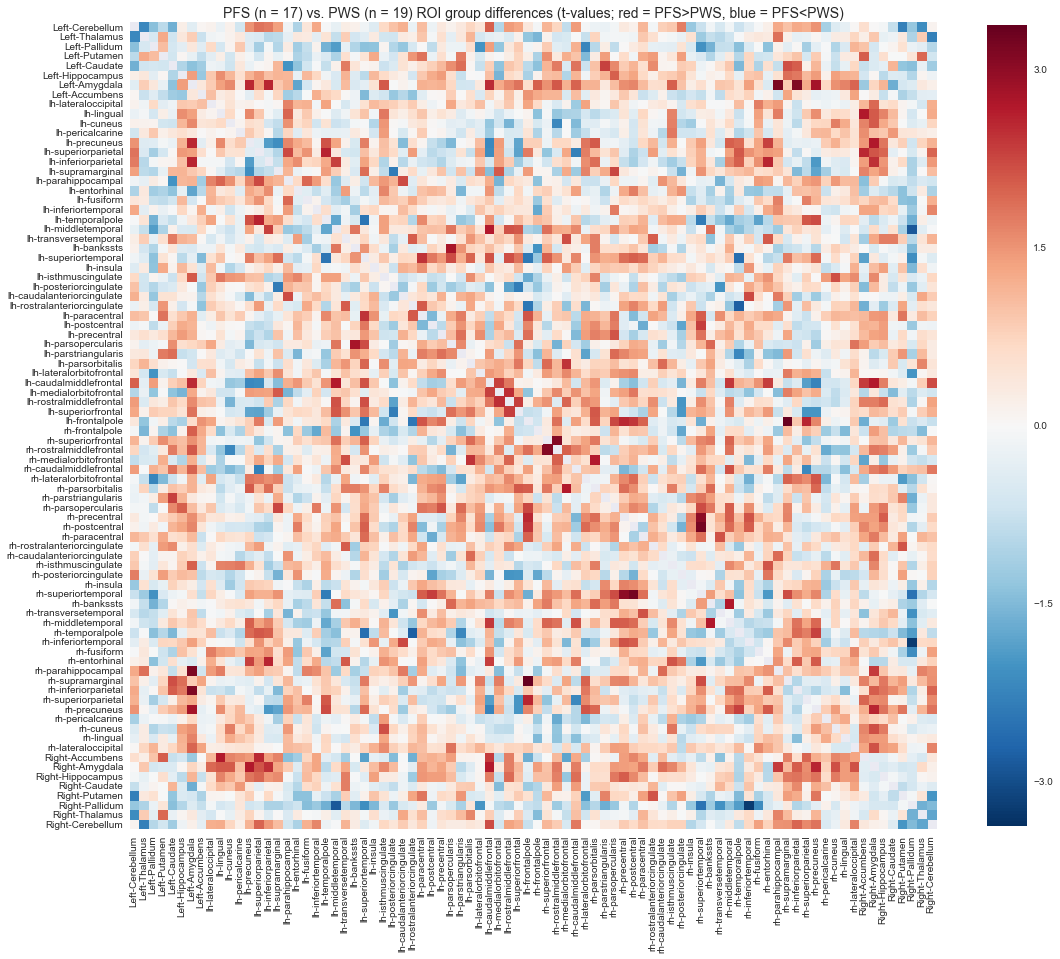

In [52]:
import matplotlib.pyplot as plt
from matplotlib.colorbar import make_axes
sns.set(style="darkgrid")

sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
f, ax = plt.subplots(figsize=(16, 16))
ax.set_title('PFS (n = %d) vs. PWS (n = %d) ROI group differences (t-values; red = PFS>PWS, blue = PFS<PWS)'%(pfs_i,pws_i),fontdict={'fontsize': 14})
sns.color_palette("RdBu_r")
sns.heatmap(t_mat, square=True, ax=ax, xticklabels=roi_list_sh,yticklabels=roi_list_sh,cbar_kws={'shrink':0.73})
f.tight_layout()
f.savefig('rs_groupdiff_chart', dpi=600, frameon=False,transparent=True,edgecolor='k',facecolor='w')#facecolor='w', , pad_inches=5)

"Strong" hemispheric symmetry differences - what about the few regions that are less strong? looks like Broca's, frontal pole,  STg/s, accumbens...

#### Connectivity matrix (PFS - PWS)

In [22]:
# copied and modified from ptx2_statistics
import matplotlib.cm as cm
color_list=[]
colors = cm.rainbow(np.linspace(0, 1, 10))
for r in range(len(anat_order)):
    #if r == 0:
    #    color_list = ['black']
    if r == 0:
        color_list.append(colors[1])
    elif r <= 7:
        color_list.append(colors[2])
    elif r <= 12:
        color_list.append(colors[3])
    elif r <= 15:
        color_list.append(colors[4])
    elif r <= 18:
        color_list.append(colors[5])
    elif r <= 24:
        color_list.append(colors[6])
    elif r <= 25:
        color_list.append(colors[7])
    elif r <= 29:
        color_list.append(colors[8])
    elif r <= 32:
        color_list.append(colors[9])
    elif r <= 41:
        color_list.append(colors[0])
    elif r <= 50:
        color_list.append(colors[0])
    elif r <= 53:
        color_list.append(colors[9])
    elif r <= 57:
        color_list.append(colors[8])
    elif r <= 58:
        color_list.append(colors[7])
    elif r <= 64:
        color_list.append(colors[6])
    elif r <= 67:
        color_list.append(colors[5])
    elif r <= 70:
        color_list.append(colors[4])
    elif r <= 75:
        color_list.append(colors[3])
    elif r <= 82:
        color_list.append(colors[2])
    else:
        color_list.append(colors[1])
color_list.reverse()

In [27]:
print p05x, p033x, p03x, p025x, p02x, p01x

238 116 108 84 42 8


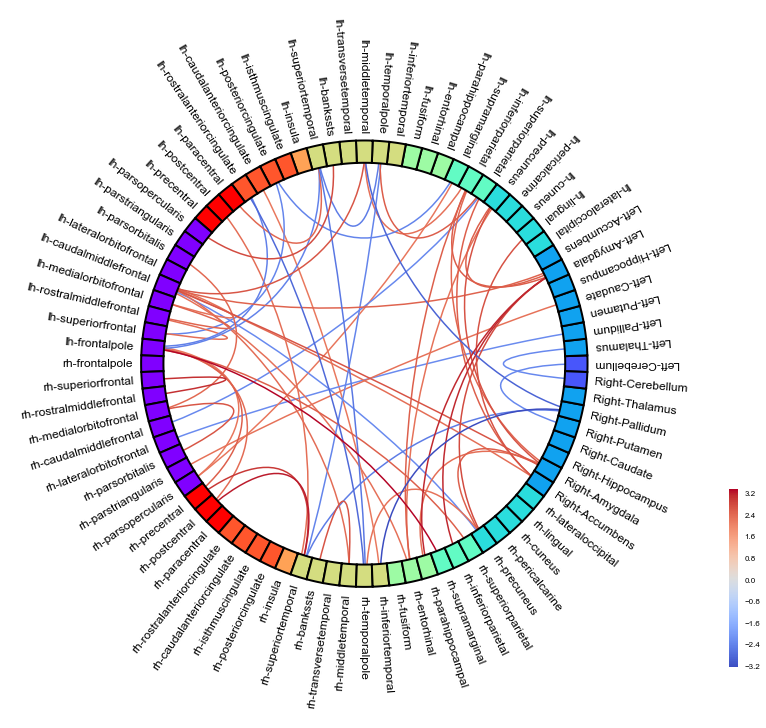

In [38]:
t_mask = copy.copy(t_mat)
t_mask[p_mat > .05] = 0

fig = plt.figure(figsize = (16,16));

mne.viz.plot_connectivity_circle(t_mat, roi_list_sh, indices=None, n_lines=p033x/2,#n_lines=None,
           node_angles=None, node_width=None, node_colors=color_list, facecolor='white',
           textcolor='black', node_edgecolor='black', linewidth=1.5, colormap='coolwarm',#'binary',
           vmin=None, vmax=None, colorbar=True, title='', colorbar_size=0.2,
           colorbar_pos=(-0.3, .2), fontsize_title=12, fontsize_names=12,
           fontsize_colorbar=8, padding=6.0, fig=fig, subplot=111, interactive=False); # run w/o mplb from start
#fig.tight_layout()
fig.savefig('rs_diff_tstat_conn_circle_anat_order.png',bbox_inches='tight',dpi=300)

Biggest hubs of group differences: left amygdala to right hemisphere, right STg to right pre/postcentral, and right temporal pole to left hemisphere (PWS>PFS). Other mixed hubs: left STg (PWS>PFS to L/R temporal pole), right precuneus.

right parahippocampal to L/R amygdala

PWS > PFS: Right Pallium to L/R superior temporal (+ L middle, R inferior temporal). 

#### structured heatmap

In [39]:
pfs_df = pd.DataFrame(rs_mean_pfs,columns=roi_list_sh)
pws_df = pd.DataFrame(rs_mean_pws,columns=roi_list_sh)
diff_df = pd.DataFrame(t_mat,columns=roi_list_sh)

In [ ]:
# http://stanford.edu/~mwaskom/software/seaborn/examples/structured_heatmap.html
import pandas as pd
import seaborn as sns
sns.set(font="monospace")
'''
df = sns.load_dataset("brain_networks", header=[0, 1, 2], index_col=0)
used_networks = [1, 5, 6, 7, 8, 11, 12, 13, 16, 17]
used_columns = (df.columns.get_level_values("network")
                          .astype(int)
                          .isin(used_networks))
df = df.loc[:, used_columns]

network_pal = sns.cubehelix_palette(len(used_networks),
                                    light=.9, dark=.1, reverse=True,
                                    start=1, rot=-2)
network_lut = dict(zip(map(str, used_networks), network_pal))

networks = df.columns.get_level_values("network")
network_colors = pd.Series(networks).map(network_lut)
'''
cmap = sns.diverging_palette(h_neg=210, h_pos=350, s=90, l=30, as_cmap=True)

print "PFS-PWS group difference t-value cluster map"
sns.clustermap(diff_df, method="average",
               figsize=(16, 16),cmap=cmap)


## PWS Correlation with SSI

In [32]:
## 
ssi_csv = pd.read_csv('/Users/kevinsitek/Dropbox (MIT)/projects/stuttering/ssi.csv')
ssi = ssi_csv['SSI']

target_ssi = np.array(ssi)
target_ssi[pfs] = 0
target = map(int,target_ssi)
data_status = map(int,np.array(pws_bin)) # only pws

print target_ssi
print target
print data_status

['23' 0 0 '20' 0 '32' '43' '30' '17' '23' 0 '34' 0 0 '37' '30' '16' 0 0
 '28' '20' 0 0 0 0 '27' 0 '16' '25' 0 0 0 '13' '17' 0 '29' '36' 0 0]
[23, 0, 0, 20, 0, 32, 43, 30, 17, 23, 0, 34, 0, 0, 37, 30, 16, 0, 0, 28, 20, 0, 0, 0, 0, 27, 0, 16, 25, 0, 0, 0, 13, 17, 0, 29, 36, 0, 0]
[1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0]


In [33]:
# align rs correlation matrix with SSI subject list
pws_ssi = []
for i,s in enumerate(pws_subs):
    a = np.array(s[1:3])
    pws_ssi.append(target[a.astype(int)-1])
print pws_ssi

[23, 20, 32, 43, 30, 23, 34, 37, 30, 16, 28, 20, 27, 16, 25, 13, 17, 29, 36]


In [34]:
#print rdat.shape
print np.array(pws_ssi).shape

(19,)


In [35]:
p001x = 0
corrout = np.zeros((84,84))
pearsons_out = np.zeros((84,84))
pearsons_pvals = np.zeros((84,84))
for r in range(0,rs_timecorr_pws.shape[1]):
    rdat = rs_timecorr_pws[:,r,:].reshape((rs_timecorr_pws.shape[0],rs_timecorr_pws.shape[2]))
    for c in range(0,rs_timecorr_pws.shape[2]):
        corr_rc = (np.corrcoef(rdat[:,c],np.array(pws_ssi)))
        pearsons_r,pearsons_p = (stats.pearsonr(rdat[:,c],np.array(pws_ssi)))

        corrout[r,c] = corr_rc[0,1]
        pearsons_out[r,c] = pearsons_r
        pearsons_pvals[r,c] = pearsons_p
        
        if pearsons_p <= 0.0001:
            sig = '*****'
        elif pearsons_p <= 0.0005:
            sig = ' ****'
        elif pearsons_p <= 0.001:
            sig = '  ***'
        elif pearsons_p <= 0.005:
            sig = '   **'
        elif pearsons_p <= 0.01:
            sig = '    *'
        else:
            sig = '     '
        
        if pearsons_p <= 0.001:
            p001x += 1
            print " %sr = %1.2f;  p = %1.6f; seed: %s - target: %s" % (sig, pearsons_r, pearsons_p, roi_list_sh[r], roi_list_sh[c])
#print corrout

   ***r = -0.71;  p = 0.000617; seed: Left-Cerebellum - target: lh-middletemporal
  ****r = -0.73;  p = 0.000384; seed: Left-Cerebellum - target: lh-lateralorbitofrontal
 *****r = -0.85;  p = 0.000005; seed: Left-Cerebellum - target: lh-medialorbitofrontal
   ***r = -0.69;  p = 0.000970; seed: Left-Cerebellum - target: rh-parsorbitalis
   ***r = -0.71;  p = 0.000587; seed: Left-Cerebellum - target: rh-middletemporal
  ****r = -0.72;  p = 0.000478; seed: lh-lateraloccipital - target: rh-temporalpole
 *****r = -0.80;  p = 0.000035; seed: lh-cuneus - target: rh-parahippocampal
  ****r = -0.73;  p = 0.000339; seed: lh-pericalcarine - target: rh-superiortemporal
   ***r = -0.70;  p = 0.000806; seed: lh-fusiform - target: lh-postcentral
   ***r = -0.71;  p = 0.000697; seed: lh-fusiform - target: rh-postcentral
   ***r = -0.71;  p = 0.000617; seed: lh-middletemporal - target: Left-Cerebellum
  ****r = -0.74;  p = 0.000321; seed: lh-middletemporal - target: Right-Cerebellum
  ****r = -0.74;  p

In [40]:
p001x

46

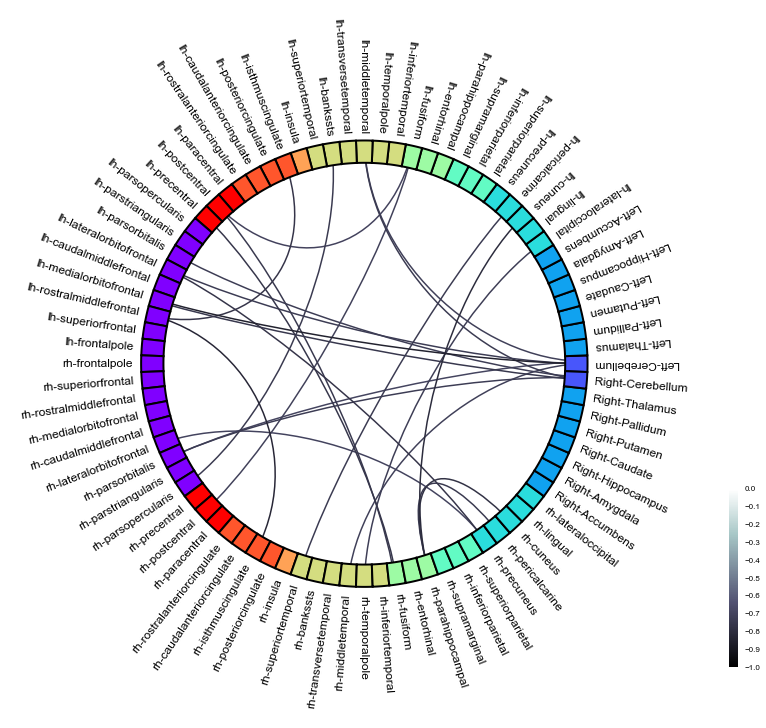

(<matplotlib.figure.Figure at 0x1133ac350>,
 <matplotlib.axes._subplots.PolarAxesSubplot at 0x11e8bef50>)

In [43]:
#c_mask = copy.copy(corrout)
c_mask = copy.copy(pearsons_out)
c_mask[pearsons_pvals > 0.001] = 0

fig = plt.figure(figsize = (16,16));

mne.viz.plot_connectivity_circle(c_mask, roi_list_sh, indices=None, n_lines=p001x/2,
           node_angles=None, node_width=None, node_colors=color_list, facecolor='white',
           textcolor='black', node_edgecolor='black', linewidth=1.5, colormap='bone',#'coolwarm',
           vmin=-1, vmax=0, colorbar=True, title='', colorbar_size=0.2,
           colorbar_pos=(-0.3, .2), fontsize_title=12, fontsize_names=12,
           fontsize_colorbar=8, padding=6.0, fig=fig, subplot=111, interactive=False) # run w/o mplb from start
#fig.savefig('rs_ssi_corr_conn_circle_anat_order.png',bbox_inches='tight',dpi=300)

All correlations are negative, so less connectivity is related to greater stuttering severity.

The strongest clusters appear to be L/R cerebellum to left frontal areas. Both left and right postcentral gyri are negatively correlated with both left and right fusiform cortex (although L/R postcentral aren't correlated with each other). Left fusiform is also less correlated with right STS, while right fusiform is correlated with left precentral. Right precuneus has strongly decreased connectivity with L/R lateral orbitofrontal and L medial orbitofrontal.

With the previous analysis (fewer subjects, different processing), SSI was negatively correlated with subcortical and right hemisphere connections, so stronger symptoms = decreased connectivity. I thought perhaps right hemisphere activity is compensatory, and those with less RH connectivity are less able to compensate for their stuttering symptoms and thus have more severe symptoms.

#### chi-squared test

In [61]:
c_neg = c_mask[c_mask<0]
print c_neg

[-0.69268281 -0.7044667  -0.74753875 -0.84845948 -0.69761504 -0.6888361
 -0.74258644 -0.70430907 -0.74102687 -0.74799047 -0.6913682  -0.70490824
 -0.7269182  -0.70512762 -0.68895355 -0.69268281 -0.70040576 -0.69855028
 -0.75138527 -0.78001728 -0.6888361  -0.70490824 -0.76334365 -0.7711971
 -0.68409817 -0.7044667  -0.68935801 -0.68190216 -0.70617554 -0.74753875
 -0.77389226 -0.7035403  -0.6799036  -0.84845948 -0.71263184 -0.75958263
 -0.78001728 -0.83639567 -0.69761504 -0.71633152 -0.75138527 -0.7269182
 -0.70861922 -0.83639567 -0.6799036  -0.70430907 -0.74799047 -0.70512762
 -0.69855028 -0.68956308 -0.74258644 -0.76334365 -0.7711971  -0.70861922
 -0.68956308 -0.74102687 -0.71434095 -0.6913682  -0.68935801 -0.77389226
 -0.71263184 -0.71633152 -0.71434095 -0.68409817 -0.68190216 -0.7035403
 -0.68895355 -0.70040576 -0.70617554 -0.75958263]


In [78]:
from scipy.stats import chisquare

c_zeros = np.zeros(np.triu(c_mask).shape)
#chi, pchi = chisquare(np.triu(c_mask),f_exp=c_zeros,axis=None)
chi, pchi = chisquare(abs(c_neg))
print chi
print pchi

0.160572681819
1.0


In [70]:
c_neg.shape

(70,)

#### FDR correction - SSI correlations

In [59]:
# FDR correction
from mne.stats import fdr_correction
import math

p_mat_ind = np.triu_indices(pearsons_pvals.shape[0],1)

wnan = pearsons_pvals[p_mat_ind]
wnan = wnan[np.nonzero(1 - np.isnan(wnan))[0]]

reject, p_mat_fdr = fdr_correction(wnan)

#print p_mat_nonan
print np.any(reject)
print reject
print np.min(p_mat_fdr)
print p_mat_fdr[p_mat_fdr<0.05]
#print np.any(np.isnan(pearsons_pvals[p_mat_ind]))

True
[False False False ..., False False False]
0.0180137054227
[ 0.01801371  0.04052387  0.02251596]


In [100]:
np.where(p_mat_fdr<.05)

(array([  37,  841, 2512]),)

In [101]:
for ix,pfdr in enumerate(p_mat_fdr[p_mat_fdr<0.05]):
    print pfdr
    pfdr_ind = np.where(p_mat_fdr<.05)[0][ix]
    print roi_list_sh[p_mat_ind[0][pfdr_ind]], roi_list_sh[p_mat_ind[1][pfdr_ind]]

0.0180137054227
Left-Cerebellum lh-medialorbitofrontal
0.0405238675082
lh-cuneus rh-parahippocampal
0.0225159584072
lh-rostralmiddlefrontal rh-isthmuscingulate


In [45]:
cereb_lmofc = rs_timecorr_pws[:,0,38]
cereb_lmofc_corr = np.corrcoef(cereb_lmofc,pws_ssi)

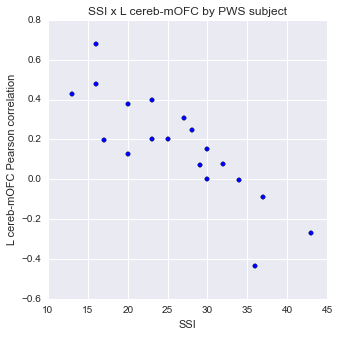

In [46]:
#plt.subplots(111,axisbg='white')
#fig,ax1 = plt.subplots(1,1)
plt.figure(num=None, figsize=(5,5), dpi=200, facecolor='w', edgecolor='k')
plt.scatter(pws_ssi,cereb_lmofc);
plt.title('SSI x L cereb-mOFC by PWS subject')
plt.xlabel('SSI')
plt.ylabel('L cereb-mOFC Pearson correlation')

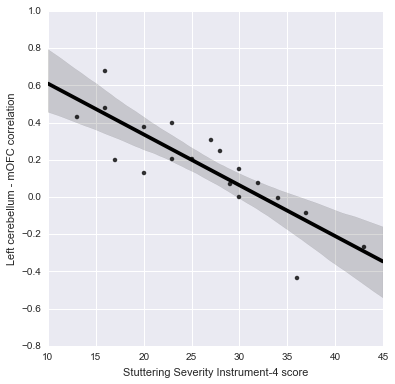

In [48]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches(6,6)
fig.set_facecolor('w')
ax = sns.regplot(x=np.array(pws_ssi), y=cereb_lmofc, color="k")
ax.set_xlabel('Stuttering Severity Instrument-4 score');
ax.set_ylabel('Left cerebellum - mOFC correlation');
#ax.set_title('Inverse relationship between L cereb-mOFC and stuttering severity')

fig.savefig('CerebOFC_SSI', dpi=600, frameon=False,transparent=True,edgecolor='k',facecolor='w')#facecolor='w', , pad_inches=5)

#### Network analysis

In [71]:
c_mask_binary = copy.copy(c_mask)
c_mask_binary[c_mask_binary!=0] = 1

sum_signif = np.sum(c_mask_binary,0)#(pearsons_pvals[pearsons_pvals<0.01])

In [72]:
sum_signif

array([ 5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  2.,  1.,  0.,  0.,  1.,  2.,  0.,  2.,
        2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,  1.,  0.,
        1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,
        2.,  0.,  3.,  0.,  0.,  0.,  2.,  1.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  4.])

In [73]:
sum_signif.shape

(84,)

In [74]:
network_cx = pd.DataFrame(data=sum_signif,index=roi_list_sh,columns=['sumCxns'])

In [75]:
network_cx_ordered = network_cx.sort(columns='sumCxns',ascending=False)
network_cx_ordered

,sumCxns
Left-Cerebellum,5
Right-Cerebellum,4
rh-parahippocampal,3
lh-middletemporal,2
rh-parsorbitalis,2
rh-precuneus,2
lh-fusiform,2
rh-fusiform,2
lh-rostralmiddlefrontal,2
lh-medialorbitofrontal,2


#### Chang's restricted network

In [77]:
ctx = ['lh','rh']
for hx,hand in enumerate(['Left','Right']):
    putamen_name = hand+'-Putamen'
    motor_name = ctx[hx]+'-precentral'
    pars_name = ctx[hx]+'-parsopercularis'
    sma_name = ctx[hx]+'-paracentral'
    stg_name = ctx[hx]+'-superiortemporal'
    
    putamen = roi_list_sh.index(putamen_name)
    motor = roi_list_sh.index(motor_name)
    sma = roi_list_sh.index(sma_name)
    stg = roi_list_sh.index(stg_name)
    pars = roi_list_sh.index(pars_name)
    
    print " r = %1.2f;  p = %1.3f; seed: %s - target: %s" % (pearsons_out[pars,stg], pearsons_pvals[pars,stg], pars_name,stg_name)
    print " r = %1.2f;  p = %1.3f; seed: %s - target: %s" % (pearsons_out[pars,motor], pearsons_pvals[pars,motor], pars_name,motor_name)
    print " r = %1.2f;  p = %1.3f; seed: %s - target: %s" % (pearsons_out[putamen,sma], pearsons_pvals[putamen,sma], putamen_name,sma_name)
    print " r = %1.2f;  p = %1.3f; seed: %s - target: %s" % (pearsons_out[putamen,motor], pearsons_pvals[putamen,motor], putamen_name,motor_name)
    print " r = %1.2f;  p = %1.3f; seed: %s - target: %s" % (pearsons_out[putamen,stg], pearsons_pvals[putamen,stg], putamen_name,stg_name)
    print "\n"

 r = -0.20;  p = 0.392; seed: lh-parsopercularis - target: lh-superiortemporal
 r = -0.39;  p = 0.088; seed: lh-parsopercularis - target: lh-precentral
 r = 0.12;  p = 0.606; seed: Left-Putamen - target: lh-paracentral
 r = -0.12;  p = 0.622; seed: Left-Putamen - target: lh-precentral
 r = -0.35;  p = 0.126; seed: Left-Putamen - target: lh-superiortemporal


 r = -0.12;  p = 0.619; seed: rh-parsopercularis - target: rh-superiortemporal
 r = 0.01;  p = 0.962; seed: rh-parsopercularis - target: rh-precentral
 r = -0.00;  p = 0.993; seed: Right-Putamen - target: rh-paracentral
 r = 0.05;  p = 0.830; seed: Right-Putamen - target: rh-precentral
 r = -0.27;  p = 0.251; seed: Right-Putamen - target: rh-superiortemporal




#### PWS - SSI corr plot

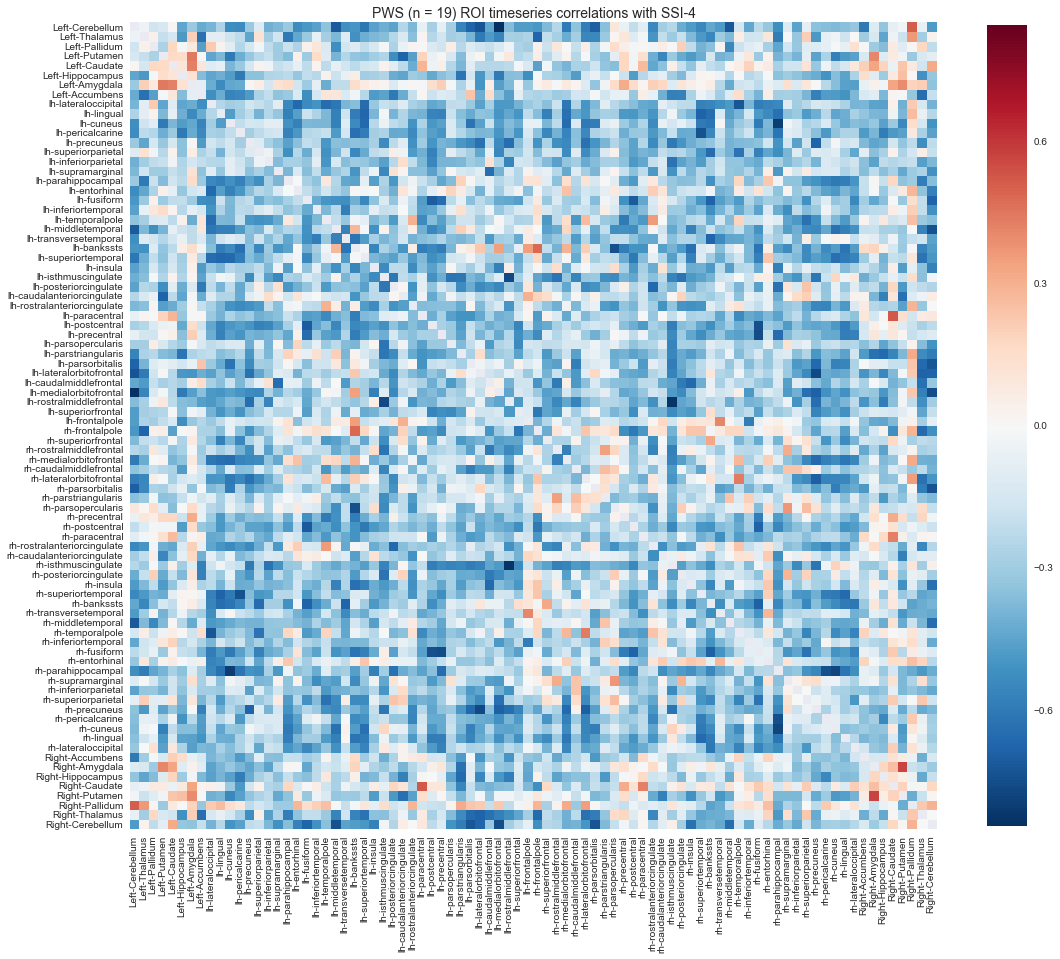

In [51]:
import matplotlib.pyplot as plt
from matplotlib.colorbar import make_axes
sns.set(style="darkgrid")

sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
f, ax = plt.subplots(figsize=(16, 16))
ax.set_title('PWS (n = %d) ROI timeseries correlations with SSI-4'%(pws_i),fontdict={'fontsize': 14})
sns.color_palette("RdBu_r")
sns.heatmap(corrout, square=True, ax=ax, xticklabels=roi_list_sh,yticklabels=roi_list_sh,cbar_kws={'shrink':0.73})
f.tight_layout()
f.savefig('rs_SSI_chart', dpi=600, frameon=False,transparent=True,edgecolor='k',facecolor='w')#facecolor='w', , pad_inches=5)

#### SSI correlation - all subjects:

In [132]:
corrout_all = np.zeros((84,84))
for r in range(0,rs_timecorr_allsubs.shape[1]):
    rdat = rs_timecorr_allsubs[:,r,:].reshape((rs_timecorr_allsubs.shape[0],rs_timecorr_allsubs.shape[2]))
    for c in range(0,rs_timecorr_allsubs.shape[2]):
        corr_allsubs_rc = (np.corrcoef(rdat[:,c],np.array(allsubs_ssi)))
        #print corr_rc
        corrout_all[r,c] = corr_allsubs_rc[0,1]
print corrout_all

NameError: name 'allsubs_ssi' is not defined

(<matplotlib.figure.Figure at 0x14391e050>,
 <matplotlib.axes.PolarAxesSubplot at 0x14391e2d0>)

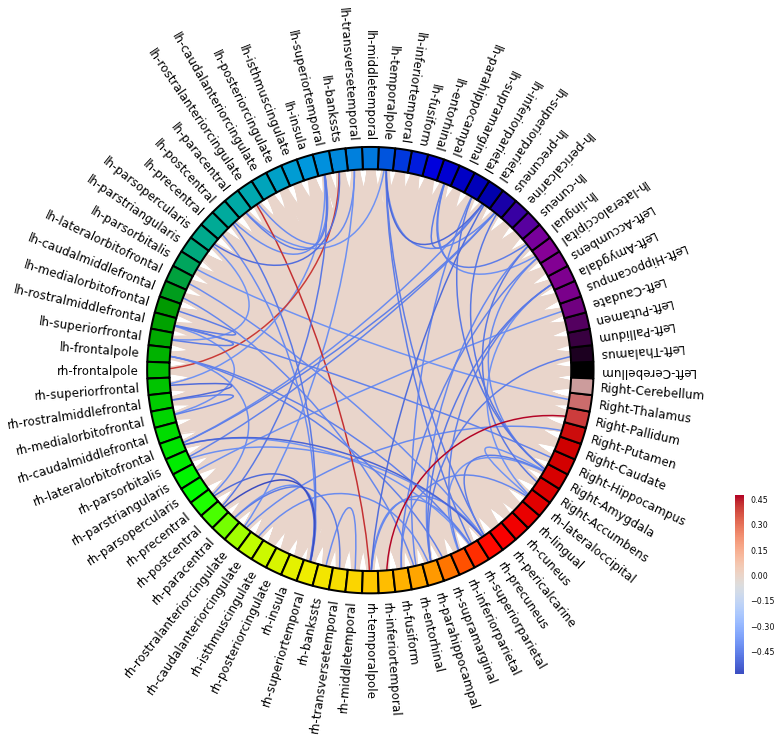

In [75]:
c_mask = copy.copy(corrout_all)
c_mask[abs(c_mask) < .4] = 0

fig = plt.figure(figsize = (16,16));

mne.viz.plot_connectivity_circle(c_mask, roi_list_sh, indices=None, n_lines=None,#n_lines=50,
           node_angles=None, node_width=None, node_colors=None, facecolor='white',
           textcolor='black', node_edgecolor='black', linewidth=1.5, colormap='coolwarm',
           vmin=None, vmax=None, colorbar=True, title='', colorbar_size=0.2,
           colorbar_pos=(-0.3, .2), fontsize_title=12, fontsize_names=12,
           fontsize_colorbar=8, padding=6.0, fig=fig, subplot=111, interactive=False) # run w/o mplb from start
#savefig(roidir+'diff_tstat_conn_circle_anat_order.png')

When the severity correlation includes both PWS and PFS groups (PFS SSI = 0), fewer right hemisphere/subcortical regions have significant negative correlations. Instead, left hemisphere motor/speech regions are correlated.

## QA measures - movement

In [25]:
# qa - movement
pws_i = 0
pfs_i = 0
pws_subs_qa = []
pfs_subs_qa = []

# look at txt file - use number of discarded trials as regressor (or correlate)
for sx,s in enumerate(sorted(os.listdir(restdir))):
    if s[0] == 'S':
        subdir = os.path.join(restdir,s,'resting')

        # ROI names
        artoutliers_file = os.path.join(subdir,'qa/art/art.rest_01_outliers.txt')
        try:
            artoutliers = pd.read_csv(artoutliers_file,header=None,skiprows=0)
        except ValueError:
            artoutliers = [0]
        #print s#, artoutliers[0], sx
        #print np.array(artoutliers)[-1]
        
        a = np.array(s[1:3])
        if a.astype(int) - 1 in pws:
            if pws_i == 0:
                artoutliers_pws = np.array(artoutliers).shape[0]
            else:
                artoutliers_pws = np.vstack((artoutliers_pws,np.array(artoutliers).shape[0]))
            pws_i += 1
            pws_subs_qa.append(s)
        else:
            if pfs_i == 0:
                artoutliers_pfs = np.array(artoutliers)[-1]
            else:
                artoutliers_pfs = np.vstack((artoutliers_pfs,np.array(artoutliers).shape[0]))
            pfs_i += 1
            pfs_subs_qa.append(s)
            
        print artoutliers
print pfs_subs_qa
print pws_subs_qa


[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
    0
0  30
[0]
['S02', 'S03', 'S05', 'S11', 'S13', 'S14', 'S18', 'S22', 'S23', 'S24', 'S25', 'S27', 'S30', 'S31', 'S32', 'S35', 'S38', 'S39']
['S01', 'S04', 'S06', 'S07', 'S08', 'S09', 'S10', 'S12', 'S15', 'S16', 'S17', 'S20', 'S21', 'S26', 'S28', 'S29', 'S33', 'S34', 'S36', 'S37']


In [24]:
# align qa list with SSI subject list

pws_qa = []
for i,s in enumerate(pws_subs_qa):
    a = np.array(s[1:3])
    pws_qa.append(target[a.astype(int)-1])
    print a
print pws_qa

01
04
06
07
08
09
10
12
15
16
17
20
21
26
28
29
33
34
36
37
[23, 20, 32, 43, 30, 17, 23, 34, 37, 30, 16, 28, 20, 27, 16, 25, 13, 17, 29, 36]


In [23]:
outliers_pws = []
for p in range(0,artoutliers_pws.shape[0]):
    outliers_pws.append(artoutliers_pws[p][0])
print outliers_pws


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [72]:
qa_corr = np.corrcoef(np.array(outliers_pws),np.array(pws_ssi))
print "PWS SSI/movement correlation coefficient = %1.4f" %qa_corr[0,1]

PWS SSI/movement correlation coefficient = nan


In [73]:
outliers_pfs = []
for p in range(0,artoutliers_pfs.shape[0]):
    outliers_pfs.append(artoutliers_pfs[p][0])
print outliers_pfs


[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


# Not in the paper

## Cerebellar segmentations

Using Buckner's functional segmentations of the cerebellum

In [188]:
pws_i = 0
pfs_i = 0
rs_timecorr_cereb_pws = []
rs_timecorr_cereb_pfs = []
pws_subs = []
pfs_subs = []

n_subs = 0
rs_timecorr_allsubs = []
all_subs = []

for sx, s in enumerate(sorted(os.listdir(restdir))):
    if s[0] == 'S' and s !='S25': # S25 has a weird lh-frontalpole - ends up nan after corrcoef & fisher
        
        subdir = os.path.join(restdir,s,'resting')

        # timecourse data
        avgwf_file = os.path.join(subdir,aparc_results,'rest_01_avgwf.txt')
        avgwf = np.loadtxt(avgwf_file)
        avgwf_cereb_file = os.path.join(subdir,'parcellations/cereb/rest_01_avgwf_cereb17.txt')
        avgwf_cereb = np.loadtxt(avgwf_cereb_file)
        
        avgwf_whole_cereb = np.hstack((avgwf,avgwf_cereb))
        
        rs_timecorr_cereb = np.zeros((avgwf_whole_cereb.shape[1],avgwf_whole_cereb.shape[1]))
        # for roi_reorder, see below in ROI names section:
        for ix, r in enumerate(range(avgwf_whole_cereb.shape[1])):#range(0,avgwf.shape[1]):
            for inx, rn in enumerate(range(avgwf_whole_cereb.shape[1])):
                #rs_timecorr[r,rn] = np.correlate(avgwf[:,r],avgwf[:,rn])
                # arctanh = Fisher transform:
                rs_timecorr_cereb[ix,inx] = np.arctanh(np.corrcoef(avgwf_whole_cereb[:,ix],avgwf_whole_cereb[:,inx])[0,1]) 
        #timefile = os.path.join(subdir,aparc_results,'time_corr.txt')
        #np.savetxt(timefile, rs_timecorr)
        
        if n_subs == 0:
            rs_timecorr_cereb_allsubs = rs_timecorr_cereb
            rs_timeseries_cereb = avgwf_whole_cereb
        else:
            rs_timecorr_cereb_allsubs = np.vstack((rs_timecorr_cereb_allsubs, rs_timecorr_cereb))
            rs_timeseries_cereb = np.vstack((rs_timeseries_cereb,avgwf_whole_cereb))
        all_subs.append(s)
        n_subs += 1
        #rs_timecorr_allsubs = np.vstack((rs_timecorr_allsubs, rs_timecorr))

        
        # add to group-level data
        a = np.array(s[1:3])
        if a.astype(int) - 1 in pws:
            if pws_i == 0:
                rs_timecorr_cereb_pws = rs_timecorr_cereb
            else:
                rs_timecorr_cereb_pws = np.vstack((rs_timecorr_cereb_pws,rs_timecorr_cereb))
            pws_i += 1
            pws_subs.append(s)
        else:
            if pfs_i == 0:
                rs_timecorr_cereb_pfs = rs_timecorr_cereb
            else:
                rs_timecorr_cereb_pfs = np.vstack((rs_timecorr_cereb_pfs,rs_timecorr_cereb))
            pfs_i += 1
            pfs_subs.append(s)

# reshape to 3D (subj x ROI x ROI)
rs_timeseries_cereb = rs_timeseries_cereb.reshape((n_subs,-1,avgwf_whole_cereb.shape[1]))
rs_timecorr_cereb_allsubs = rs_timecorr_cereb_allsubs.reshape((n_subs,-1,avgwf_whole_cereb.shape[1]))
rs_timecorr_cereb_pws = rs_timecorr_cereb_pws.reshape((pws_i,-1,avgwf_whole_cereb.shape[1]))
rs_timecorr_cereb_pfs = rs_timecorr_cereb_pfs.reshape((pfs_i,-1,avgwf_whole_cereb.shape[1]))

In [189]:
rs_timecorr_cereb_pws.shape

(20, 97, 97)

In [190]:
sumstats_file = os.path.join(subdir,'parcellations/cereb/rest_01_summary_cereb17.stats')
sumstats = pd.read_csv(sumstats_file,header=None,skiprows=53)
print sumstats[0][0][28:43]

  17Networks_2 


In [191]:
print sumstats

                                                    0
0     1   2     27839   222712.0  17Networks_2    ...
1     2   4       462     3696.0  17Networks_4    ...
2     3   5        24      192.0  17Networks_5    ...
3     4   7      1448    11584.0  17Networks_7    ...
4     5   8      6564    52512.0  17Networks_8    ...
5     6  10      1026     8208.0  17Networks_10   ...
6     7  11       461     3688.0  17Networks_11   ...
7     8  12       646     5168.0  17Networks_12   ...
8     9  13       168     1344.0  17Networks_13   ...
9    10  14       143     1144.0  17Networks_14   ...
10   11  15       365     2920.0  17Networks_15   ...
11   12  16      2828    22624.0  17Networks_16   ...
12   13  17       515     4120.0  17Networks_17   ...


In [192]:
roi_list_sh_w_cereb = copy.copy(roi_list_sh)
for cn in range(sumstats.shape[0]):
    roi_list_sh_w_cereb.append('cereb'+sumstats[0][cn][30:43])

In [193]:
print roi_list_sh_w_cereb

['Left-Cerebellum', 'Left-Thalamus', 'Left-Pallidum', 'Left-Putamen', 'Left-Caudate', 'Left-Hippocampus', 'Left-Amygdala', 'Left-Accumbens', 'lh-lateraloccipital', 'lh-lingual', 'lh-cuneus', 'lh-pericalcarine', 'lh-precuneus', 'lh-superiorparietal', 'lh-inferiorparietal', 'lh-supramarginal', 'lh-parahippocampal', 'lh-entorhinal', 'lh-fusiform', 'lh-inferiortemporal', 'lh-temporalpole', 'lh-middletemporal', 'lh-transversetemporal', 'lh-bankssts', 'lh-superiortemporal', 'lh-insula', 'lh-isthmuscingulate', 'lh-posteriorcingulate', 'lh-caudalanteriorcingulate', 'lh-rostralanteriorcingulate', 'lh-paracentral', 'lh-postcentral', 'lh-precentral', 'lh-parsopercularis', 'lh-parstriangularis', 'lh-parsorbitalis', 'lh-lateralorbitofrontal', 'lh-caudalmiddlefrontal', 'lh-medialorbitofrontal', 'lh-rostralmiddlefrontal', 'lh-superiorfrontal', 'lh-frontalpole', 'rh-frontalpole', 'rh-superiorfrontal', 'rh-rostralmiddlefrontal', 'rh-medialorbitofrontal', 'rh-caudalmiddlefrontal', 'rh-lateralorbitofront

In [194]:
t_mat = np.zeros((rs_timecorr_cereb_pws.shape[1],rs_timecorr_cereb_pws.shape[2]))
p_mat = np.zeros((rs_timecorr_cereb_pws.shape[1],rs_timecorr_cereb_pws.shape[2]))
p05x = 0
for col in range(84,rs_timecorr_cereb_pws.shape[1]):
    for row in range(0,rs_timecorr_cereb_pws.shape[2]):
        t, p = stats.ttest_ind(rs_timecorr_cereb_pfs[:,row,col],rs_timecorr_cereb_pws[:,row,col])
        t_mat[row,col] = t
        p_mat[row,col] = p
        #print 't-value = %5f, p-value = %5f'%(t,p)
        
        if p <= 0.001:
            sig = '****'
        elif p <= 0.005:
            sig = ' ***'
        elif p <= 0.01:
            sig = '  **'
        elif p <=.02:
            sig = '   *'
        else:
            sig = '    '
        
        if p <= 0.05:
            print " %st = %1.2f;  p = %1.3f; seed: %s - target: %s" % (sig, t, p, roi_list_sh_w_cereb[col], roi_list_sh_w_cereb[row])
            p05x += 1

  ***t = -3.43;  p = 0.002; seed: cereb17Networks_2  - target: Left-Caudate
     t = 2.12;  p = 0.041; seed: cereb17Networks_2  - target: rh-transversetemporal
  ***t = -3.43;  p = 0.002; seed: cereb17Networks_2  - target: cereb17Networks_13
    *t = 2.71;  p = 0.010; seed: cereb17Networks_4  - target: lh-rostralanteriorcingulate
     t = 2.08;  p = 0.045; seed: cereb17Networks_4  - target: lh-parstriangularis
     t = 2.25;  p = 0.031; seed: cereb17Networks_4  - target: rh-parahippocampal
  ***t = 3.19;  p = 0.003; seed: cereb17Networks_4  - target: Right-Hippocampus
 ****t = -3.63;  p = 0.001; seed: cereb17Networks_5  - target: Left-Cerebellum
     t = -2.12;  p = 0.041; seed: cereb17Networks_5  - target: Left-Amygdala
   **t = -2.98;  p = 0.005; seed: cereb17Networks_5  - target: lh-lateraloccipital
    *t = 2.67;  p = 0.011; seed: cereb17Networks_5  - target: lh-lateralorbitofrontal
     t = -2.07;  p = 0.046; seed: cereb17Networks_5  - target: rh-lateralorbitofrontal
     t = -2.1

## Yeo's functional cortical parcellations

In [195]:
pws_i = 0
pfs_i = 0
rs_timecorr_yeo_pws = []
rs_timecorr_yeo_pfs = []
pws_subs = []
pfs_subs = []

n_subs = 0
rs_timecorr_allsubs = []
all_subs = []

for sx, s in enumerate(sorted(os.listdir(restdir))):
    if s[0] == 'S' and s !='S25': # S25 has a weird lh-frontalpole - ends up nan after corrcoef & fisher
        
        subdir = os.path.join(restdir,s,'resting')

        # timecourse data
        avgwf_file = os.path.join(subdir,aparc_results,'rest_01_avgwf.txt')
        avgwf = np.loadtxt(avgwf_file)
        avgwf_cereb_file = os.path.join(subdir,'parcellations/cereb/rest_01_avgwf_cereb17.txt')
        avgwf_cereb = np.loadtxt(avgwf_cereb_file)
        avgwf_yeo_file = os.path.join(subdir,'parcellations/yeo/rest_01_avgwf_yeo17.txt')
        avgwf_yeo = np.loadtxt(avgwf_yeo_file)
        
        avgwf_whole_yeo = np.hstack((avgwf,avgwf_cereb,avgwf_yeo))
        
        rs_timecorr_yeo = np.zeros((avgwf_whole_yeo.shape[1],avgwf_whole_yeo.shape[1]))
        # for roi_reorder, see below in ROI names section:
        for ix, r in enumerate(range(avgwf_whole_yeo.shape[1])):#range(0,avgwf.shape[1]):
            for inx, rn in enumerate(range(avgwf_whole_yeo.shape[1])):
                #rs_timecorr[r,rn] = np.correlate(avgwf[:,r],avgwf[:,rn])
                # arctanh = Fisher transform:
                rs_timecorr_yeo[ix,inx] = np.arctanh(np.corrcoef(avgwf_whole_yeo[:,ix],avgwf_whole_yeo[:,inx])[0,1]) 
        #timefile = os.path.join(subdir,aparc_results,'time_corr.txt')
        #np.savetxt(timefile, rs_timecorr)
        
        if n_subs == 0:
            rs_timecorr_yeo_allsubs = rs_timecorr_yeo
            rs_timeseries_yeo = avgwf_whole_yeo
        else:
            rs_timecorr_yeo_allsubs = np.vstack((rs_timecorr_yeo_allsubs, rs_timecorr_yeo))
            rs_timeseries_yeo = np.vstack((rs_timeseries_yeo,avgwf_whole_yeo))
        all_subs.append(s)
        n_subs += 1
        #rs_timecorr_allsubs = np.vstack((rs_timecorr_allsubs, rs_timecorr))

        
        # add to group-level data
        a = np.array(s[1:3])
        if a.astype(int) - 1 in pws:
            if pws_i == 0:
                rs_timecorr_yeo_pws = rs_timecorr_yeo
            else:
                rs_timecorr_yeo_pws = np.vstack((rs_timecorr_yeo_pws,rs_timecorr_yeo))
            pws_i += 1
            pws_subs.append(s)
        else:
            if pfs_i == 0:
                rs_timecorr_yeo_pfs = rs_timecorr_yeo
            else:
                rs_timecorr_yeo_pfs = np.vstack((rs_timecorr_yeo_pfs,rs_timecorr_yeo))
            pfs_i += 1
            pfs_subs.append(s)

# reshape to 3D (subj x ROI x ROI)
rs_timeseries_yeo = rs_timeseries_yeo.reshape((n_subs,-1,avgwf_whole_yeo.shape[1]))
rs_timecorr_yeo_allsubs = rs_timecorr_yeo_allsubs.reshape((n_subs,-1,avgwf_whole_yeo.shape[1]))
rs_timecorr_yeo_pws = rs_timecorr_yeo_pws.reshape((pws_i,-1,avgwf_whole_yeo.shape[1]))
rs_timecorr_yeo_pfs = rs_timecorr_yeo_pfs.reshape((pfs_i,-1,avgwf_whole_yeo.shape[1]))

In [196]:
print avgwf_cereb[0]
print avgwf_yeo[0]

[ 0.49758  0.56344 -0.15569  2.3709   3.23263  0.3357  -0.94344  1.36599
  1.98555  3.15934  7.35554  2.47117  0.81792]
[ 0.49759  0.56345 -0.15567  2.3709   3.23263  0.33568 -0.94345  1.36598
  1.98555  3.15935  7.35555  2.47117  0.81791]


Looks like the two parcellations are the same.... Ran Yeo in a new working directory, so probably not that. Need to check maps of the parcellations?

In [141]:
print rs_timecorr_yeo_pws.shape

sumstats_file = os.path.join(subdir,'parcellations/yeo/rest_01_summary_yeo17.stats')
sumstats = pd.read_csv(sumstats_file,header=None,skiprows=53)
print sumstats[0][0][28:43]

roi_list_sh_w_cereb_yeo = copy.copy(roi_list_sh_w_cereb)
for cn in range(sumstats.shape[0]):
    roi_list_sh_w_cereb_yeo.append('yeo'+sumstats[0][cn][30:43])

(20, 110, 110)
  17Networks_2 


In [144]:
print roi_list_sh_w_cereb_yeo

['Left-Cerebellum', 'Left-Thalamus', 'Left-Pallidum', 'Left-Putamen', 'Left-Caudate', 'Left-Hippocampus', 'Left-Amygdala', 'Left-Accumbens', 'lh-lateraloccipital', 'lh-lingual', 'lh-cuneus', 'lh-pericalcarine', 'lh-precuneus', 'lh-superiorparietal', 'lh-inferiorparietal', 'lh-supramarginal', 'lh-parahippocampal', 'lh-entorhinal', 'lh-fusiform', 'lh-inferiortemporal', 'lh-temporalpole', 'lh-middletemporal', 'lh-transversetemporal', 'lh-bankssts', 'lh-superiortemporal', 'lh-insula', 'lh-isthmuscingulate', 'lh-posteriorcingulate', 'lh-caudalanteriorcingulate', 'lh-rostralanteriorcingulate', 'lh-paracentral', 'lh-postcentral', 'lh-precentral', 'lh-parsopercularis', 'lh-parstriangularis', 'lh-parsorbitalis', 'lh-lateralorbitofrontal', 'lh-caudalmiddlefrontal', 'lh-medialorbitofrontal', 'lh-rostralmiddlefrontal', 'lh-superiorfrontal', 'lh-frontalpole', 'rh-frontalpole', 'rh-superiorfrontal', 'rh-rostralmiddlefrontal', 'rh-medialorbitofrontal', 'rh-caudalmiddlefrontal', 'rh-lateralorbitofront

In [143]:
t_mat = np.zeros((rs_timecorr_yeo_pws.shape[1],rs_timecorr_yeo_pws.shape[2]))
p_mat = np.zeros((rs_timecorr_yeo_pws.shape[1],rs_timecorr_yeo_pws.shape[2]))
p05x = 0
for col in range(84,rs_timecorr_yeo_pws.shape[1]):
    for row in range(0,rs_timecorr_yeo_pws.shape[2]):
        t, p = stats.ttest_ind(rs_timecorr_yeo_pfs[:,row,col],rs_timecorr_yeo_pws[:,row,col])
        t_mat[row,col] = t
        p_mat[row,col] = p
        #print 't-value = %5f, p-value = %5f'%(t,p)
        
        if p <= 0.001:
            sig = '****'
        elif p <= 0.005:
            sig = ' ***'
        elif p <= 0.01:
            sig = '  **'
        elif p <=.02:
            sig = '   *'
        else:
            sig = '    '
        
        if p <= 0.01:
            print " %st = %1.2f;  p = %1.3f; seed: %s - target: %s" % (sig, t, p, roi_list_sh_w_cereb_yeo[col], roi_list_sh_w_cereb_yeo[row])
            p05x += 1

  ***t = -3.43;  p = 0.002; seed:   17Networks_2  - target: Left-Caudate
  ***t = -3.43;  p = 0.002; seed:   17Networks_2  - target:   17Networks_13
  ***t = -3.43;  p = 0.002; seed:   17Networks_2  - target: yeo17Networks_13
  ***t = 3.19;  p = 0.003; seed:   17Networks_4  - target: Right-Hippocampus
 ****t = -3.63;  p = 0.001; seed:   17Networks_5  - target: Left-Cerebellum
   **t = -2.98;  p = 0.005; seed:   17Networks_5  - target: lh-lateraloccipital
 ****t = -3.63;  p = 0.001; seed:   17Networks_5  - target:   17Networks_8 
 ****t = -3.63;  p = 0.001; seed:   17Networks_5  - target: yeo17Networks_8 
  ***t = -3.01;  p = 0.005; seed:   17Networks_7  - target: rh-rostralmiddlefrontal
 ****t = -3.63;  p = 0.001; seed:   17Networks_8  - target:   17Networks_5 
 ****t = -3.63;  p = 0.001; seed:   17Networks_8  - target: yeo17Networks_5 
  ***t = -3.43;  p = 0.002; seed:   17Networks_13 - target:   17Networks_2 
  ***t = -3.43;  p = 0.002; seed:   17Networks_13 - target: yeo17Networks_2

## Prediction

In [56]:
import pylab as pl
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import StratifiedShuffleSplit, cross_val_score, LeaveOneOut, ShuffleSplit, KFold
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import KFold, ShuffleSplit, StratifiedShuffleSplit, StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVR, SVC
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import RidgeCV, ElasticNetCV, LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score, r2_score, f1_score, matthews_corrcoef
from sklearn.decomposition import PCA
from IPython.display import display

In [57]:
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesRegressor


clf = Pipeline([('scaler', StandardScaler()), ('pca', PCA()), ('model', ExtraTreesRegressor(compute_importances=True))])
clf1 = Pipeline([('scaler', StandardScaler()), ('model', ExtraTreesRegressor(compute_importances=True))])
clf2 = ExtraTreesRegressor(compute_importances=True)

make clf choice inside training - nested cross validation (outer, inner to evaluate each clf)

extract just upper triangle of correlation matrix (np.___) - 

give correlation matrix ^^

#### Predictions, PWS group only:

In [58]:
print rs_timecorr_pws.shape
#print rs_timecorr_pfs.shape
print np.array(pws_ssi)

(20, 84, 84)
[23 20 32 43 30 17 23 34 37 30 16 28 20 27 16 25 13 17 29 36]


In [ ]:
timecorr_score = np.zeros(rs_timecorr_pws.shape[1])
for model in [clf,clf1,clf2]:
    print "\n %s" % model
    for r in range(0,rs_timecorr_pws.shape[1]):
        
        timecorr_score_r = cross_val_score(model,rs_timecorr_pws[:,r,:],np.array(pws_ssi), cv=5, scoring="r2")  
        timecorr_score[r] = timecorr_score_r.mean()
        
        print "%s time correlation:" % names[r]
        print timecorr_score_r.mean()


#### Predictions, both groups:

In [62]:
print target
allsubs_ssi = []
for i,s in enumerate(sorted(pfs_subs+pws_subs)):
    a = np.array(s[1:3])
    allsubs_ssi.append(target[a.astype(int)-1])
print allsubs_ssi
print len(allsubs_ssi)


[23, 0, 0, 20, 0, 32, 43, 30, 17, 23, 0, 34, 0, 0, 37, 30, 16, 0, 0, 28, 20, 0, 0, 0, 0, 27, 0, 16, 25, 0, 0, 0, 13, 17, 0, 29, 36, 0, 0]
[23, 0, 0, 20, 0, 32, 43, 30, 17, 23, 0, 34, 0, 0, 37, 30, 16, 0, 28, 20, 0, 0, 0, 27, 0, 16, 25, 0, 0, 0, 13, 17, 0, 29, 36, 0, 0]
37


In [ ]:
timecorr_allsubs_score = np.zeros(rs_timecorr_allsubs.shape[1])
for model in [clf,clf1,clf2]:
    print "\n %s" % model
    for r in range(0,rs_timecorr_allsubs.shape[1]):
        
        timecorr_allsubs_score_r = cross_val_score(model,rs_timecorr_allsubs[:,r,:],np.array(allsubs_ssi), cv=5, scoring="r2")  
        timecorr_allsubs_score[r] = timecorr_score_r.mean()
        
        #print "Time correlation of %s %s" % (names[r],model)  #status
        print "%s time correlation:" % names[r]
        print timecorr_allsubs_score_r.mean()#*-1 
    #Negative MSE?? issues on github ---> https://github.com/scikit-learn/scikit-learn/issues/2439


#### Using 2d matrix

In [171]:
for model in [clf,clf1,clf2]:
    print "\n %s" % model
    
    timeseries_allsubs_score = cross_val_score(model,rs_timeseries_2d,np.array(allsubs_ssi), cv=5, scoring="r2")  

    #print "Time correlation of %s %s" % (names[r],model)  #status
    print "time series correlation:"
    print timeseries_allsubs_score#.mean()#*-1 
    #Negative MSE?? issues on github ---> https://github.com/scikit-learn/scikit-learn/issues/2439



 Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, n_components=None, whiten=False)), ('model', ExtraTreesRegressor(bootstrap=False, compute_importances=None,
          criterion='mse', max_depth=None, max_features='auto',
          max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
          min_samples_split=2, n_estimators=10, n_jobs=1, oob_score=False,
          random_state=None, verbose=0))])
time series correlation:
[-0.2877959  -0.16602477 -0.09312432  0.20559571  0.03635521]

 Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', ExtraTreesRegressor(bootstrap=False, compute_importances=None,
          criterion='mse', max_depth=None, max_features='auto',
          max_leaf_nodes=None, min_density=None, min_samples_leaf=1,
          min_samples_split=2, n_estimators=10, n_jobs=1, oob_score=False,
          random_state=None, verbose=0))])
time series correlation:
[ 0.27

## Classification

In [458]:
# cross validation  
from sklearn.cross_validation import StratifiedShuffleSplit, cross_val_score, LeaveOneOut, ShuffleSplit, KFold

cv = ShuffleSplit(len(target),n_iter=1000, test_size=0.1)   #<-----increase n_iter=5000 for publication 
#class sklearn.cross_validation.ShuffleSplit(n, n_iter=10, test_size=0.1, train_size=None, 
#                                            indices=True, random_state=None, n_iterations=None)¶
#(more iterations, the closer we get to the true mean of classification accuracy. Less variance)

In [459]:
print rs_timecorr_allsubs.shape

(30, 84, 84)


In [481]:
rs_timecorr_allsubs_2d = rs_timecorr_allsubs.reshape((rs_timecorr_allsubs.shape[0],-1))

In [482]:
rs_timecorr_allsubs_2d.shape

(30, 7056)

In [483]:
print rs_timecorr_allsubs_2d

[[        inf  0.657445    0.33167107 ...,  0.10514641  0.66791287
          inf]
 [        inf  0.35887419  0.29391643 ...,  0.27711296 -0.03198223
          inf]
 [        inf  0.55110489  0.39516754 ...,  0.01603104  0.5489779
          inf]
 ..., 
 [        inf  0.44265826  0.30156692 ...,  0.39929099  0.24173664
          inf]
 [        inf  0.52608278 -0.18432218 ...,  0.22865726  0.39411786
          inf]
 [        inf  0.06315677  0.26040811 ...,  0.18127702  0.29698947
          inf]]


#### Manipulate data matrix

Take the top triangle of each subject's correlation matrix, which becomes a 1D array.
Combine all subjects into a 2D matrix (which is what sklearn wants anyway).

In [514]:
in_data = np.zeros((rs_timecorr_allsubs.shape[0],3486))
for sx in range(0,rs_timecorr_allsubs.shape[0]):
    data = rs_timecorr_allsubs[sx,:,:]
    data_ind = np.triu_indices(data.shape[0],1)
    data_top = data[data_ind]
    in_data[sx,:] = data_top

In [515]:

from sklearn.ensemble import ExtraTreesClassifier

## USE: TARGET, DATA_STATUS, DATA_BRAIN_THICKNESS, DATA_THICKNESS_STATUS
targets = np.asarray(allsubs_ssi)#.astype(int)
#data = np.hstack((data_brain_Volume, data_brain_Len_Avg, data_brain_avg))

#for r in range(0,rs_timecorr_pws.shape[1]):
#data = rs_timecorr_allsubs[:,r,:]
#data = rs_timecorr_allsubs_2d

#data_ind = np.triu_indices(data.shape[0],1)
#data = data[data_ind]
#data = data[np.nonzero(1 - np.isinf(data))[0]]
#data[data == np.inf] = 0
data = in_data

#classifier
#clf_class = Pipeline([('scaler', StandardScaler()), ('model', ExtraTreesClassifier())])
clf_grid = GridSearchCV(SVC(), {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']})
clf_class = Pipeline([('scale', StandardScaler()), #('PCA', PCA(n_components=38)),
                      ('model', ExtraTreesClassifier(n_estimators=200))
                      #('model', clf_grid)
                      ])

#cross validation
#cv = StratifiedShuffleSplit(targets,n_iter=10, test_size=0.1) 
cv = StratifiedKFold(targets, n_folds=10) 

scores = {}
permutation_scores = {}
pvalue = {}

#scores = cross_val_score(clf_class,data, targets, cv=cv, scoring="f1")

'''
for train, test in cv:
    clf_class.fit(data[train], targets[train])
    pred_targets = clf_class.predict(data[test])
    clf_class.steps[-1][1].feature_importances_
'''
##=====PERMUTATION TEST SCORE===========This will tell us if the f1 scores are significant
from sklearn.cross_validation import permutation_test_score 
#http://scikit-learn.org/stable/auto_examples/plot_permutation_test_for_classification.html

scores, permutation_scores, pvalue = permutation_test_score(
            clf_class, data, targets, cv=cv, scoring="accuracy",  n_permutations=200, n_jobs=8)
            #<--run in interactive qsub with 8jobs

#=====Print scores=======
#print names[r]
print "Scores: %1.2f +- %1.2f" % (
    scores.mean(),
    scores.std())

print("Classification score %s (pvalue : %s)" % (permutation_scores.mean(), pvalue))


#all_scores[r] = permutation_scores.mean()
#perm_pvals[r] = pvalue

Scores: 0.85 +- 0.00
Classification score 0.4506 (pvalue : 0.00497512437811)


In [500]:
print data.shape

(30, 7056)


In [504]:
data_top = data[data_ind]

In [505]:
print data_top.shape

(435,)
